In [45]:
import time
import numpy
import numpy as np
import matplotlib.pyplot as plt
import copy
import shelve
import  scipy.stats as st
from scipy.optimize import fsolve

In [46]:
class data_generator():
    '''To generate correlated posson spike chain using the Dichotomized gaussian distribution'''
    def __init__(self, M, N_r, t, r, Sigma):
        self.M = M
        gamma = st.norm.ppf(r)

        def dichtomy(gamma_i,gamma_j,Sigma_ij,r_i,r_j):
            '''Sovle the covariance equation by dichtomy method'''
            a = -1 + 1e-6
            b = 1-1e-6

            for i in range(30):
                f_a = st.multivariate_normal.cdf((gamma_i,gamma_j), mean = (0,0), cov = np.array([[1,a],[a,1]])) - r_i*r_j - Sigma_ij
                f_b = st.multivariate_normal.cdf((gamma_i,gamma_j), mean = (0,0), cov = np.array([[1,b],[b,1]])) - r_i*r_j - Sigma_ij
                c = (a+b)/2
                f_c = st.multivariate_normal.cdf((gamma_i,gamma_j), mean = (0,0), cov = np.array([[1,c],[c,1]])) - r_i*r_j - Sigma_ij
                #print(f_a,f_b,f_c)

                if f_c == 0 :
                    a = c
                    b = c
                    break
                elif (f_c*f_a)>0:
                    a = c
                else:
                    b = c
            
            return  (a+b)/2

        Lambda = np.zeros(Sigma.shape)
        for i in range(M+N_r):
            for j in range(M+N_r-i-1):
                if Sigma[i,i+j+1]!=0:
                    Lambda[i,i+j+1] = dichtomy(gamma[i], gamma[i+j+1], Sigma[i,i+j+1], r[i], r[i+j+1])
        Lambda = Lambda + Lambda.T + np.eye(M+N_r)
        self.gamma = gamma
        self.Lambda  = Lambda
        self.t = t
        self.Sigma = Sigma
    def __next__(self):
    
        U = np.random.multivariate_normal(mean = self.gamma, cov = self.Lambda, size = self.t)

        x = np.heaviside(U[:, :self.M], 0 )
        r = np.heaviside(U[:,self.M:], 0)
        return x, r

In [47]:
M = 100
N_r = 1
r = [0.02 for i in range(100)] + [0.06]
r = np.array(r)
var_b = r*(1-r)

Sigma = np.eye(M+N_r )*r
Sigma[:25,-1] = 0.1
Sigma[-1,:25] = 0.1
Sigma[:25,:25] = 0.04

Sigma[25:50, -1] = 0.075
Sigma[-1, 25:50] = 0.075
Sigma[25:50, 25:50] = 0.04
Sigma[50:100,50:100] = 0.2
Sigma = Sigma*np.sqrt(var_b.reshape(-1,1).dot(var_b.reshape(1,-1)))
Sigma[np.eye(M+N_r)==1] = r*(1-r)
g = data_generator(M, N_r, 20000, r, Sigma)

In [48]:
def logistic(x):
    y = 1/(1 + np.exp(-x))
    #y[y!=y] = np.heaviside(x,0)[y!=y]*(1-1e-10) + 1e-11
    return y

In [49]:
#To define the neuron model
class Network():
    def __init__(self,N=1, M = 100, N_r = 1, N_q = 2):
        
        self.N =N
        self.M = M
        self.N_r = N_r
        self.N_q = N_q
        self.dt = 1e-3
        self.tau = 10e-3
        self.tau = self.tau/self.dt
        self.w = np.ones((N, M))*0.15
        self.q = np.zeros(( N_q, N))/(N)
        self.x_hat = np.zeros((N,1))
        self.x = np.zeros((M,1))
        self.r = np.zeros((N_r,1))
        self.eta_w = 0.075
        self.eta_q = np.array([4.25e-3, 4.25e-4])
        self.eta_g = 2e-3
        self.tau_g = 2e-3
        self.threshold = 6
        self.gamma = 8e-6
        self.u_rest = 0
        self.u = np.ones((N,1))*self.u_rest
        
        self.g = np.zeros((self.N,1))
        self.v = np.zeros((self.M,1))
        self.xi = np.zeros((self.N_q,1))
        self.xi[1] = 1
        self.sigma_tilde = np.ones((self.N,1))*0.02
        
    def evolve(self,x):
        
        self.x = x
        self.u = self.u - 1/self.tau*(self.u-self.u_rest) + self.w.dot(self.x.reshape(-1,1))
        self.x_hat = np.heaviside(logistic((self.u - self.threshold)) - np.random.rand(self.N,1), 0)
        
        
    def learning(self,x_sequence,r_sequence):
        
        outputspike = [ ]
        g_list = []
        for t in range(len(x_sequence)-1):
            
            self.v = (1 - 1/self.tau)*self.v + x_sequence[t].reshape(-1,1)
            self.g = (1 - 1/self.tau)*self.g + self.x_hat.reshape(-1,1)
            self.xi[0] = (1 - 1/self.tau)*self.xi[0] + r_sequence[t].reshape(-1,1)
            self.F = logistic((self.q*self.xi).sum())
            g_list.append(self.g*1)
            self.evolve(x_sequence[t])
            outputspike.append(self.x_hat*1)
            
            #print((xi + r_sequence[t+1].reshape(-1,1)).shape)
            
            self.sigma = logistic((self.u - self.threshold))
            self.sigma_tilde = (1 - self.eta_g)*self.sigma_tilde + self.eta_g*self.sigma +1e-30
            
            self.sigma_prime = self.sigma*(1 - self.sigma)
            
            self.w += self.eta_w*( self.sigma_prime*( ((self.q*self.xi).sum() 
                                                       - np.log(self.sigma_tilde/(1-self.sigma_tilde)))).dot(self.v.T) - self.gamma*self.w)
            self.w[self.w<0] = 0
            #print(self.q.shape,self.xi.shape,(self.x_hat - self.F).shape)
            self.q = self.q + self.eta_q.reshape(self.N_q,self.N_r)*self.xi*(self.sigma - self.F)
            #print(self.q.shape)
            
        return outputspike,g_list
    


In [50]:
g.t = 100
net = Network(1,M,1)
w_list = []
q_list = []
w_list.append(net.w*1)
q_list.append(net.q*1)
for i in range(1000):
    #print(i, end = ';')
    x,r = next(g)
    output = net.learning(x,r)
    w_list.append(net.w*1)
    q_list.append(net.q*1)
q_list = np.asarray(q_list)
w_list = np.asarray(w_list)

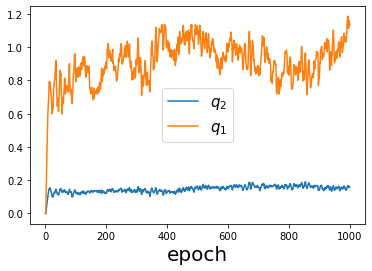

In [53]:
plt.plot(q_list[:,1], label = r'$q_2$')
plt.plot(q_list[:,0],  label = r'$q_1$')
plt.xlabel('epoch', fontsize = 20)
plt.legend(fontsize = 15)
plt.savefig('fig/WolfgangMaass2010-1.pdf', bbox_inches = 'tight')

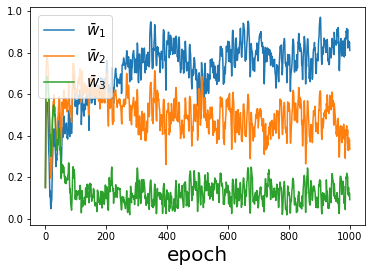

In [55]:
plt.plot(abs(w_list[:,0,:25]).mean(1), label = r'$\bar{w}_1$')
plt.plot(abs(w_list[:,0,25:50]).mean(1), label = r'$\bar{w}_2$')
plt.plot(abs(w_list[:,0,50:]).mean(1), label = r'$\bar{w}_3$')
plt.xlabel('epoch', fontsize = 20)
plt.legend(fontsize = 15)
plt.savefig('fig/WolfgangMaass2010-2.pdf', bbox_inches = 'tight')

In [56]:
#定义神经网络模型
class Network():
    def __init__(self,N=1, M = 100, N_r = 1, N_q = 2):
        
        self.N =N
        self.M = M
        self.N_r = N_r
        self.N_q = N_q
        self.dt = 1e-3
        self.tau = 10e-3
        self.tau = self.tau/self.dt
        self.w = np.ones((N, M))*0.15
        self.q = np.zeros(( N_q, N))/(N)
        self.x_hat = np.zeros((N,1))
        self.x = np.zeros((M,1))
        self.r = np.zeros((N_r,1))
        self.eta_w = 0.075
        self.eta_q = np.array([4.25e-3, 4.25e-4])
        self.eta_g = 2e-3
        self.tau_g = 2e-3
        self.threshold = 6
        self.gamma = 8e-6
        self.u_rest = 0
        self.u = np.ones((N,1))*self.u_rest
        
        self.g = np.zeros((self.N,1))
        self.v = np.zeros((self.M,1))
        self.xi = np.zeros((self.N_q,1))
        self.xi[1] = 1
        self.sigma_tilde = np.ones((self.N,1))*0.02
        
    def evolve(self,x):
        
        self.x = x
        
        self.u = self.u - 1/self.tau*(self.u-self.u_rest) + self.w.dot(self.x.reshape(-1,1))
        #print(self.Omega.dot(self.x_hat.reshape(-1,1)) + self.F.dot(self.x.reshape(-1,1)),'u',self.u)
        #print(self.Omega.dot(self.x_hat.reshape(-1,1)).shape)
        self.x_hat = np.heaviside(logistic((self.u - self.threshold)) - np.random.rand(self.N,1), 0)
        
        
    def learning(self,x_sequence,r_sequence):
        
        
        
        outputspike = [ ]
        g_list = []
        #print(len(x_sequence)-1,';;;')
        for t in range(len(x_sequence)-1):
            
            self.v = (1 - 1/self.tau)*self.v + x_sequence[t].reshape(-1,1)
            self.g = (1 - 1/self.tau)*self.g + self.x_hat.reshape(-1,1)
            self.xi[0] = (1 - 1/self.tau)*self.xi[0] + r_sequence[t].reshape(-1,1)
            self.F = logistic((self.q*self.xi).sum())
            g_list.append(self.g*1)
            self.evolve(x_sequence[t])
            outputspike.append(self.x_hat*1)
            
            #print((xi + r_sequence[t+1].reshape(-1,1)).shape)
            
            self.sigma = logistic((self.u - self.threshold))
            self.sigma_tilde = (1 - self.eta_g)*self.sigma_tilde + self.eta_g*self.sigma +1e-30
            
            self.sigma_prime = self.sigma*(1 - self.sigma)
            
            self.w += self.eta_w*( self.sigma_prime*( ((self.u-self.threshold) 
                                                       - np.log(self.sigma_tilde/(1-self.sigma_tilde)))).dot(self.v.T) - self.gamma*self.w)
            self.w[self.w<0] = 0
            #print(self.q.shape,self.xi.shape,(self.x_hat - self.F).shape)
            #self.q = self.q + self.eta_q.reshape(self.N_q,self.N_r)*self.xi*(self.sigma - self.F)
            #print(self.q.shape)
            
        return outputspike,g_list

In [57]:
g.t = 100
net = Network(1,M,1)
net.gamma = 1e-4
net.eta_w= 1e-2
w_list = []
q_list = []
w_list.append(net.w*1)
q_list.append(net.q*1)
for i in range(1000):
    #print(i, end = ';')
    x,r = next(g)
    output = net.learning(x,r)
    w_list.append(net.w*1)
    q_list.append(net.q*1)
q_list = np.asarray(q_list)
w_list = np.asarray(w_list)

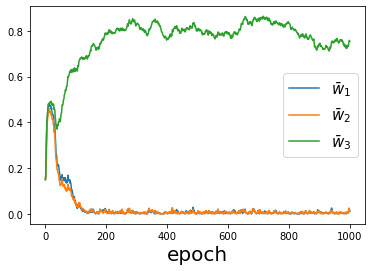

In [58]:
plt.plot(abs(w_list[:,0,:25]).mean(1), label = r'$\bar{w}_1$')
plt.plot(abs(w_list[:,0,25:50]).mean(1), label = r'$\bar{w}_2$')
plt.plot(abs(w_list[:,0,50:]).mean(1), label = r'$\bar{w}_3$')
plt.xlabel('epoch', fontsize = 20)
plt.legend(fontsize = 15)
plt.savefig('fig/WolfgangMaass2010-3.pdf', bbox_inches = 'tight')